# Scalar Bilevel ROF
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-\bar{u}\|^2 + \beta\lambda^2\\
\text{s.t. } \hat{u} = arg\min_u \frac{1}{2}\|u-f\|^2+\lambda\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample to learn the optimal parameter for the ROF image denoising model.

In [1]:
using Pkg, Random, Images, TestImages, LinearAlgebra
using AbstractOperators
using StructuredOptimization

In [9]:
include("../BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [3]:
Random.seed!(123); # For reproductibility

## Load dataset

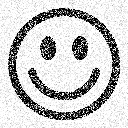

In [53]:
# Noisy image
Y = datasetimage("1_smiley_noisy","../datasets/smiley_dataset")
Y[Y .< 0] .= 0. # Make sure pixels are in range
Y[Y .> 1] .= 1.
Gray.(Y)

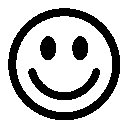

In [5]:
# Ground truth
Yt = datasetimage("1_smiley_original","../datasets/smiley_dataset")
Yt[Yt .< 0] .= 0. # Make sure pixels are in range
Yt[Yt .> 1] .= 1.
Gray.(Yt)

## Bilevel Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [126]:
# Minimizing the ROF dual formulation
function lower_level_solver(lambda,Y,V,U)
    @minimize ls(-V'*U+Y) + conj(lambda*norm(U,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return Gray.(-V'*(~U)+Y)
end

# Upper level cost
function upper_level_cost(Yt,X,beta,lambda)
    return 0.5*norm(vcat((X-Yt)...)) + beta*lambda^2
end

upper_level_cost (generic function with 1 method)

In [127]:
V = Variation(size(Y)) # Define the finite differences gradient operator
U = Variable(size(V,1)...)
beta = 0.1;

In [128]:
using Distributed

lambda_range = 0.01:0.01:10;

costs = Float64[]
@distributed for lambda in lambda_range
    X = lower_level_solver(lambda,Y,V,U)
    push!(costs,upper_level_cost(Yt,X,beta,lambda))
    #println("The cost for $lambda of this iteration")
end


Task (done) @0x0000000112be5b10

In [129]:
# Saving generated data
using JLD
save("scalar_rof_cost.jld", "lambda", lambda_range, "costs", costs)

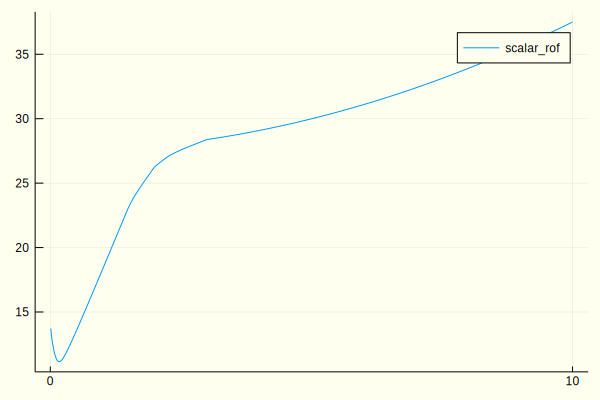

In [130]:
using Plots
d = load("scalar_rof_cost.jld")
plot(d["lambda"],d["costs"],label="scalar_rof",xticks = 0:10:100, background_color = :ivory)

## Gradient Calculation
In this section we will define a mechanism for calculated the gradient of the reduced functional
$$
f(\lambda) = J(S(\lambda),\lambda)
$$

### Active / Inactive Set
Let us see how the active and inactive set are distributed within the image

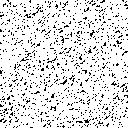

In [131]:
VY = V*Y
norms = sqrt.(sum(VY.^2, dims=2))
norms = reshape(norms,128,128) # Inactive set
Gray.(norms .> 1e-3)

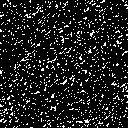

In [132]:
Gray.(norms .< 1e-3) # Active set

### AdjointOperator Definition

In [14]:
include("../BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [15]:
Adj = ScalarROFAdjointOperator(1.2,((2,2),(4,2)))

MethodError: MethodError: no method matching fun_name(::ScalarROFAdjointOperator{Float64,2})
Closest candidates are:
  fun_name(!Matched::Main.BilevelImagingParameterLearning.NormWL21) at /Users/dvillacis/workspace/BilevelImagingParameterLearning.jl/src/norms/NormWL21.jl:90
  fun_name(!Matched::Main.BilevelImagingParameterLearning.ScalarROFAdjointOperator) at /Users/dvillacis/workspace/BilevelImagingParameterLearning.jl/src/operators/ScalarROFAdjointOperator.jl:33

In [1]:
typeof(((2,2),(4,2)))

Tuple{Tuple{Int64,Int64},Tuple{Int64,Int64}}

In [6]:
Adj*ones(10,10)

MethodError: MethodError: no method matching codomainType(::ScalarROFAdjointOperator{Float64,2})
Closest candidates are:
  codomainType(!Matched::AdjointOperator) at /Users/dvillacis/.julia/packages/AbstractOperators/xTEMf/src/calculus/AdjointOperator.jl:37
  codomainType(!Matched::MyLinOp{N,M,C,D}) where {N, M, C, D} at /Users/dvillacis/.julia/packages/AbstractOperators/xTEMf/src/linearoperators/MyLinOp.jl:48
  codomainType(!Matched::Zeros{C,N,D,M}) where {C, N, D, M} at /Users/dvillacis/.julia/packages/AbstractOperators/xTEMf/src/linearoperators/Zeros.jl:53
  ...